#GIN Using Default values: Politifact and CONTENT

In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-+.html
Looking in links: https://data.pyg.org/whl/torch-+.html


In [ ]:
from torch_geometric.datasets import UPFD #importing the UPFD Dataset


In [ ]:
test_data_gos = UPFD(root=".", name="gossipcop", feature="content",split="test")
train_data_gos = UPFD(root=".", name="gossipcop", feature="content", split="train")
val_data_gos = UPFD(root=".", name="gossipcop", feature="content", split="val")

test_data_pol = UPFD(root=".", name="politifact", feature="content",split="test")
train_data_pol = UPFD(root=".", name="politifact", feature="content", split="train")
val_data_pol = UPFD(root=".", name="politifact", feature="content", split="val")
train_data_pol = train_data_pol + val_data_pol

print("Gossipcop Dataset")
print("Train Samples: ", len(train_data_gos))
print("Validation Samples: ", len(val_data_gos))
print("Test Samples: ", len(test_data_gos))

print("Politifact Dataset")
print("Train Samples: ", len(train_data_pol))
print("Validation Samples: ", len(val_data_pol))
print("Test Samples: ", len(test_data_pol))

Processing...


Gossipcop Dataset
Train Samples:  1092
Validation Samples:  546
Test Samples:  3826
Politifact Dataset
Train Samples:  93
Validation Samples:  31
Test Samples:  221


Done!


In [ ]:
train_data_pol[0].edge_index


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  8,  8, 16, 16, 16, 16, 16, 16,
         24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
         24, 24, 24, 24, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 60],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
         37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
         55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]])

##Loading Dataset Using DataLoader for train data and test data of Politifact

In [ ]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_data_pol, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data_pol, batch_size=256, shuffle=False)

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import LeakyReLU, Softmax, Linear, SELU,Dropout
from torch_geometric.nn import SAGEConv, global_max_pool, GATv2Conv, TopKPooling, global_mean_pool
from torch_geometric.transforms import ToUndirected
from torch.nn import LeakyReLU


##Defining Architecture of GIN Using 3 GIN Convolutional layers  with 3 unit MLP

In [ ]:
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU
from torch_geometric.nn import GINConv, global_max_pool

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Net, self).__init__()
        self.conv1 = GINConv(Sequential(Linear(in_channels, hidden_channels[0]), ReLU()))
        self.conv2 = GINConv(Sequential(Linear(hidden_channels[0], hidden_channels[1]), ReLU()))
        self.conv3 = GINConv(Sequential(Linear(hidden_channels[1], hidden_channels[2]), ReLU()))

        self.full1 = Linear(hidden_channels[2], hidden_channels[3])
        self.full2 = Linear(hidden_channels[3], hidden_channels[4])
        self.full3 = Linear(hidden_channels[4], hidden_channels[5])

        self.softmax = Linear(hidden_channels[5], out_channels)

        # dropouts
        self.dp1 = torch.nn.Dropout(0.2)
        self.dp2 = torch.nn.Dropout(0.2)
        self.dp3 = torch.nn.Dropout(0.2)

    def forward(self, x, edge_index, batch):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = self.conv2(h, edge_index)
        h = F.relu(h)
        h = self.conv3(h, edge_index)
        h = F.relu(h)

        h = global_max_pool(h, batch)

        h = self.full1(h)
        h = F.relu(h)
        h = self.dp1(h)
        h = self.full2(h)
        h = F.relu(h)
        h = self.dp2(h)
        h = self.full3(h)
        h = F.relu(h)
        h = self.dp3(h)

        h = self.softmax(h)

        return torch.sigmoid(h)


In [ ]:
from torch.autograd import Variable
from sklearn.metrics import accuracy_score, f1_score 

##Train and Test of model using Hyperparameters

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(test_data_pol.num_features,[512,512,512,256,256,256],1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  #using adam optimiser and the learning rate as lr= 0.0001
lossff = torch.nn.BCELoss() #binary cross entropy loss
print(device)

cpu


In [ ]:
def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        # print(out)

        loss = lossff(torch.reshape(out,(-1,)), data.y.float())
        # print(loss)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        # print(out)
        loss = lossff(torch.reshape(out,(-1,)), data.y.float())
        # print(loss)
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())
    # print(all_preds)
    accuracy, f1 = metrics(all_preds, all_labels)
    return total_loss / len(test_loader.dataset), accuracy, f1


def metrics(preds, gts):
    preds = torch.round(torch.cat(preds))
    gts = torch.cat(gts)
    # print(preds.cpu().numpy())

    acc = accuracy_score(preds.cpu().numpy(), gts.cpu().numpy())
    f1 = f1_score(preds.cpu().numpy(), gts.cpu().numpy())
    return acc, f1



In [ ]:
import matplotlib.pyplot as plt

wloss = []
train_losses = []
test_losses = []
test_accs = []
weighted_loss = 0
exp_param = 0.8
best_test_loss = float('inf')

for epoch in range(500):
  train_loss = train(epoch)
  test_loss, test_acc, test_f1 = test(epoch)
  weighted_loss = exp_param * (weighted_loss) + (1 - exp_param) * (test_loss / len(test_loader.dataset))
  
  wloss.append(weighted_loss / (1 - exp_param ** (epoch + 1)))
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  test_accs.append(test_acc)

  if test_loss < best_test_loss:
    best_test_loss = test_loss

  print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.5f} | '
        f'TestLoss: {test_loss:.5f} | TestAcc: {test_acc:.5f} | TestF1: {test_f1:.2f}')



Epoch: 00 |  TrainLoss: 0.69545 | TestLoss: 0.69309 | TestAcc: 0.51131 | TestF1: 0.68
Epoch: 01 |  TrainLoss: 0.69405 | TestLoss: 0.69318 | TestAcc: 0.51131 | TestF1: 0.68
Epoch: 02 |  TrainLoss: 0.69343 | TestLoss: 0.69328 | TestAcc: 0.48869 | TestF1: 0.60
Epoch: 03 |  TrainLoss: 0.69299 | TestLoss: 0.69346 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 04 |  TrainLoss: 0.69399 | TestLoss: 0.69370 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 05 |  TrainLoss: 0.69252 | TestLoss: 0.69392 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 06 |  TrainLoss: 0.69168 | TestLoss: 0.69408 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 07 |  TrainLoss: 0.69013 | TestLoss: 0.69436 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 08 |  TrainLoss: 0.69084 | TestLoss: 0.69471 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 09 |  TrainLoss: 0.69069 | TestLoss: 0.69504 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 10 |  TrainLoss: 0.69243 | TestLoss: 0.69535 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 11 |  TrainLoss: 0.69326 | TestLoss: 0.69550 | 

##Plot of Test Accuracy over best Loss and Best Accuracy Epoch

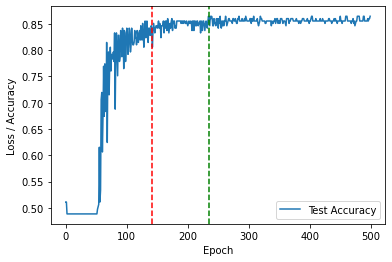

In [ ]:
plt.plot(test_accs, label='Test Accuracy')

# Add legend and axis labels
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')

# Add marker for best epoch
best_epoch_loss = test_losses.index(min(test_losses))
best_epoch_acc = test_accs.index(max(test_accs))
plt.axvline(x=best_epoch_loss, color='r', linestyle='--', label='Best Loss Epoch')
plt.axvline(x=best_epoch_acc, color='g', linestyle='--', label='Best Acc Epoch')

plt.show()